# Project

In [1]:
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 100

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from sklearn.manifold import TSNE
from sklearn.model_selection import KFold

os.chdir('C:/Users/RH/Documents/GeekBrains/DataScience course/Numpy, Pandas, Sklearn (продолжение)/Project')

Очистка и подготовка данных

In [2]:
df_train = pd.read_csv('train.csv', sep = ',', encoding = 'utf8')
df_test = pd.read_csv('test.csv', sep = ',', encoding = 'utf8')

In [537]:
#исправляем орфографическую ошибку
df_train = df_train.rename(columns={"Helthcare_2": "Healthcare_2"}) 
df_test = df_test.rename(columns={"Helthcare_2": "Healthcare_2"})

#заменяем нереалистичные данные
#df_train['HouseYear'].sort_values(ascending=False)
df_train['HouseYear'].replace({4968: 1968}, inplace=True) 

#заменяем буквы на цифры в категориальных переменных
df_train['Ecology_2'].replace({'A': 0, 'B': 1}, inplace=True)
df_train['Ecology_3'].replace({'A': 0, 'B': 1}, inplace=True)
df_train['Shops_2'].replace({'A': 0, 'B': 1}, inplace=True)

df_test['Ecology_2'].replace({'A': 0, 'B': 1}, inplace=True)
df_test['Ecology_3'].replace({'A': 0, 'B': 1}, inplace=True)
df_test['Shops_2'].replace({'A': 0, 'B': 1}, inplace=True)

#удаляем кривые данные
df_train = df_train.drop(df_train[df_train['HouseYear'] == 20052011].index)
df_train = df_train.drop(df_train[df_train['KitchenSquare'] >= 1000].index)
df_train = df_train.drop(df_train[df_train['LifeSquare'] >= 4000].index)
df_train = df_train.drop(df_train[df_train['Square'] >= 250].index)

#заполняем пропуски Healthcare_1
df_train['Healthcare_1'] = np.where(np.isnan(df_train['Healthcare_1']), 
                                    np.mean(df_train['Healthcare_1']), df_train['Healthcare_1'])
df_test['Healthcare_1'] = np.where(np.isnan(df_test['Healthcare_1']), 
                                   np.mean(df_train['Healthcare_1']), df_test['Healthcare_1'])

#заменяем квартиры где 0 комнат или слишком много комнат на медиану
df_train['Rooms'] = np.where((df_train['Rooms'] ==0) | (df_train['Rooms'] >=6), 
                             int(np.median(df_train['Rooms'])), df_train['Rooms'])
df_test['Rooms'] = np.where((df_test['Rooms'] ==0) | (df_test['Rooms'] >6), 
                            int(np.median(df_train['Rooms'])), df_test['Rooms'])

#заменяем квартиры где площадь очень маленькая, на медиану
df_train['Square'] = np.where(df_train['Square'] <= 10, np.median(df_train['Square']), df_train['Square'])
df_test['Square'] = np.where(df_test['Square'] <= 10, np.median(df_train['Square']), df_test['Square'])

#заменяем этажность дома где слишком большая, на медиану
df_train['HouseFloor'] = np.where(df_train['HouseFloor'] >= 75, np.median(df_train['HouseFloor']), df_train['HouseFloor'])
df_test['HouseFloor'] = np.where(df_test['HouseFloor'] >= 75, np.median(df_train['HouseFloor']), df_test['HouseFloor'])
df_test['Floor'] = np.where(df_test['Floor'] >= 75, np.median(df_train['Floor']), df_test['Floor'])

#создаем новую переменную, этаж относительно этажности дома и заменяем там где этаж строго больше этажности, на медиану
df_train['RatioFloor'] = df_train['Floor']/df_train['HouseFloor']
df_test['RatioFloor'] = df_test['Floor']/df_test['HouseFloor']
df_train['RatioFloor'] = np.where(df_train['RatioFloor'] > 1, 
                np.median(df_train['RatioFloor'] <= 1), df_train['RatioFloor'])
df_test['RatioFloor'] = np.where(df_test['RatioFloor'] > 1, 
                np.median(df_train['RatioFloor']<= 1), df_test['RatioFloor'])

df_train['HouseFloor'] = np.round(np.where(df_train['Floor']/df_train['HouseFloor'] > 1, 
                                  df_train['Floor']/df_train['RatioFloor'], df_train['HouseFloor']))
df_test['HouseFloor'] = np.round(np.where(df_test['Floor']/df_test['HouseFloor'] > 1, 
                                  df_test['Floor']/df_test['RatioFloor'], df_test['HouseFloor']))

#создаем доп переменную - одноэтажный дом
df_train['1FloorHouse'] = np.where((df_train['HouseFloor']<=1) & (df_train['Floor']<=1), 1, 0)
df_test['1FloorHouse'] = np.where((df_test['HouseFloor']<=1) & (df_test['Floor']<=1), 1, 0)

#создаем доп переменную - дом от 2 этажей, и живет на 1 этаже
df_train['1Floor'] = np.where((df_train['HouseFloor']>1) & (df_train['Floor']<=1), 1, 0)
df_test['1Floor'] = np.where((df_test['HouseFloor']>1) & (df_test['Floor']<=1), 1, 0)

#создаем доп переменную - дом от 2 этажей, и живет на последнем этаже
df_train['LastFloor'] = np.where((df_train['HouseFloor']>1) &  (df_train['RatioFloor'] == 1), 1, 0)
df_test['LastFloor'] = np.where((df_test['HouseFloor']>1) & (df_test['RatioFloor'] == 1), 1, 0)

#заменяем нереалистичные по площади кухни
df_test['KitchenSquare'] = np.where(df_test['KitchenSquare'] >= 200, 
                                    np.median(df_train['KitchenSquare']), df_test['KitchenSquare'])

df_train['KitchenSquare'] = np.where((df_train['KitchenSquare']/df_train['Square']>=0.85) | (df_train['KitchenSquare'] <=3), 
                                     0, df_train['KitchenSquare'])
df_test['KitchenSquare'] = np.where((df_test['KitchenSquare']/df_test['Square']>=0.85) | (df_test['KitchenSquare'] <=3), 
                                    0, df_test['KitchenSquare'])

df_train['KitchenShare'] = df_train['KitchenSquare']/df_train['Square']
df_test['KitchenShare'] = df_test['KitchenSquare']/df_test['Square']

df_train['KitchenSquare'] = np.where((df_train['KitchenShare']>=0.4) | (df_train['KitchenShare'] <=0.05), 
                                     0, df_train['KitchenSquare'])
df_test['KitchenSquare'] = np.where((df_test['KitchenShare']>=0.4) | (df_test['KitchenShare'] <=0.05), 
                                     0, df_test['KitchenSquare'])

pd.options.mode.chained_assignment = None  # default='warn'
def KitchenShare(data):

    
    for i in range(1, 5):
        ratio = np.median(df_train['KitchenShare'].loc[(data['Rooms'] == i) & (df_train['KitchenShare'] != 0)])
        x = data['KitchenSquare'].loc[data['Rooms'] == i]
        y = ratio*data['Square'].loc[data['Rooms'] == i]
        x = np.where(x == 0, y, x)
        data['KitchenSquare'].loc[data['Rooms'] == i] = x
        

    ratio = np.median(df_train['KitchenShare'].loc[(data['Rooms'] >= 5) & (df_train['KitchenShare'] != 0)])    
    x = data['KitchenSquare'].loc[data['Rooms'] >= 5]
    y = ratio*data['Square'].loc[data['Rooms'] >= 5]
    x = np.where(x == 0, y, x)
    data['KitchenSquare'].loc[data['Rooms'] >= 5] = x
    
    
KitchenShare(df_train)
KitchenShare(df_test)

df_train['KitchenShare'] = df_train['KitchenSquare']/df_train['Square']
df_test['KitchenShare'] = df_test['KitchenSquare']/df_test['Square']

#цена 1 кв.м
df_train['Price/m'] = df_train['Price']/df_train['Square']

#df_test['Square'].sort_values(ascending=True).head(10)

In [538]:
#df_train.shape
#df_train.isna().sum()
#df_train.describe
df_train.head(5)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751       6.000000      7   
1  15053          41    3.0  65.683640   40.049543       8.000000      7   
2   4765          53    2.0  44.947953   29.197612       6.397526      8   
3   5809          58    2.0  53.352981   52.731512       9.000000      8   
4  10783          99    1.0  39.649192   23.776169       7.000000     11   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040          1          1        33      7976   
1         9.0       1978   0.000070          1          1        46     10309   
2        12.0       1968   0.049637          1          1        34      7759   
3        17.0       1977   0.437885          1          1        23      5735   
4        12.0       1976   0.012339          1          1        35      5776   

   Social_3  Healthcare_1  Healthcare_2  Shops_1  Shops_2          Price  \
0         5   1142.839299             0       11        1  184966.930730   
1         1    240.000000             1       16        1  300009.450063   
2         0    229.000000             1        3        1  220925.908524   
3         3   1084.000000             0        5        1  175616.227217   
4         1   2078.000000             2        4        1  150226.531644   

   RatioFloor  1FloorHouse  1Floor  LastFloor  KitchenShare      Price/m  
0    0.777778            0       0          0      0.125048  3854.958571  
1    0.777778            0       0          0      0.121796  4567.491245  
2    0.666667            0       0          0      0.142332  4915.149522  
3    0.470588            0       0          0      0.168688  3291.591637  
4    0.916667            0       0          0      0.176548  3788.892642

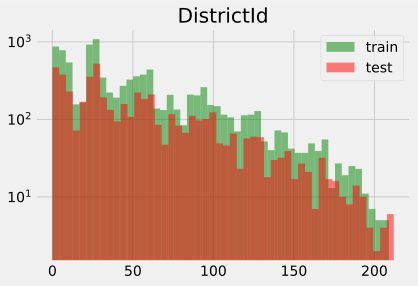

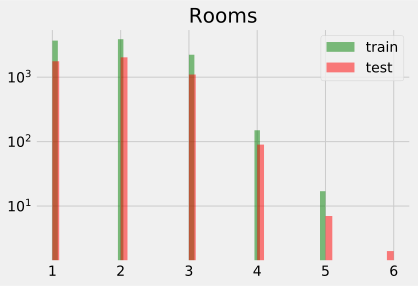

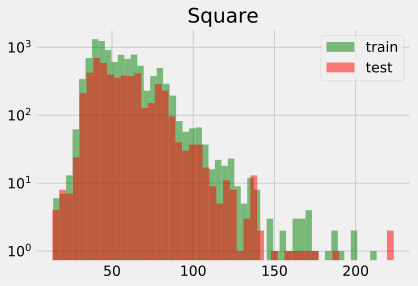

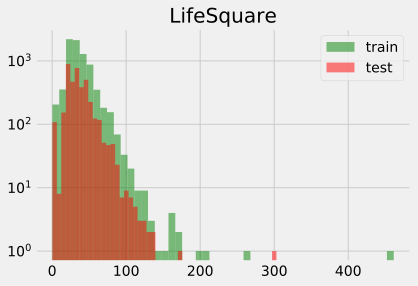

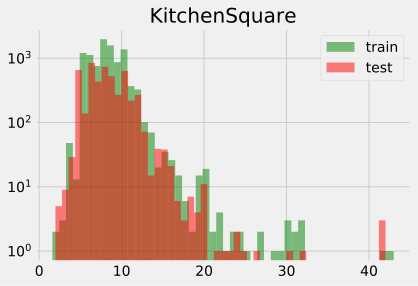

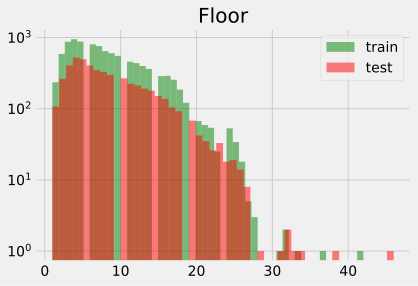

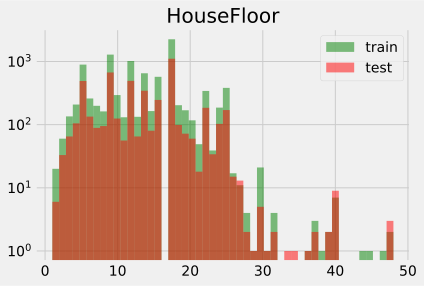

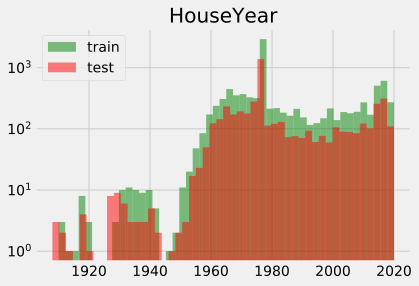

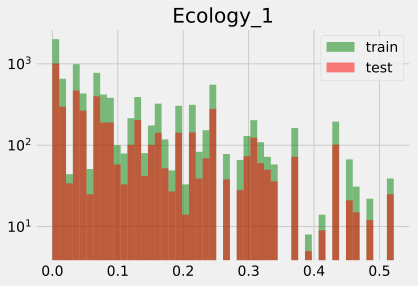

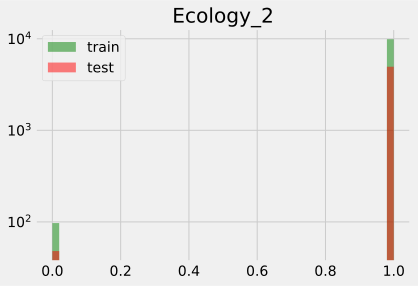

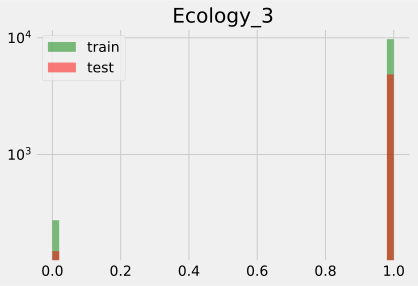

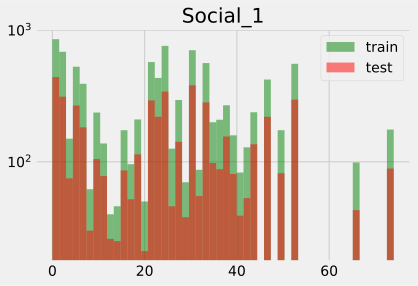

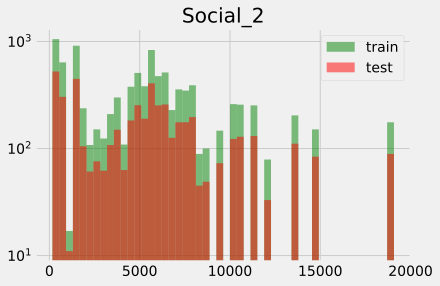

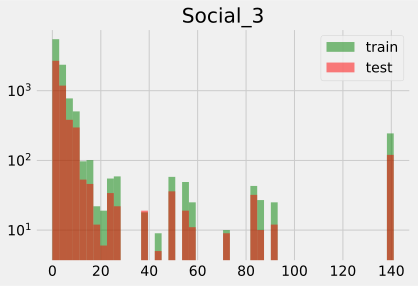

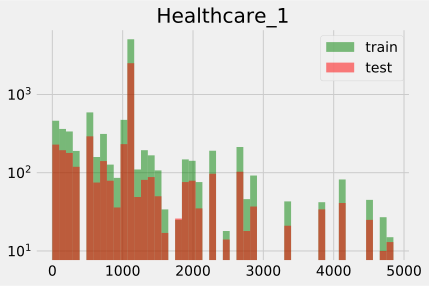

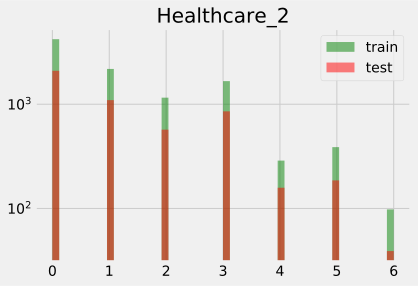

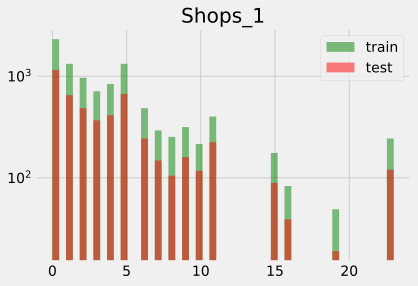

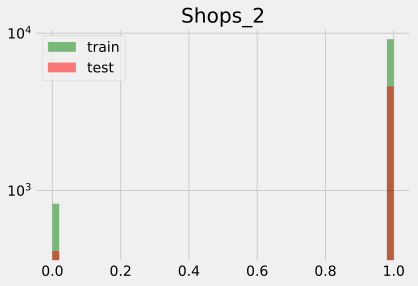

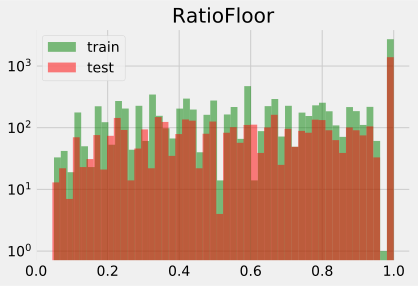

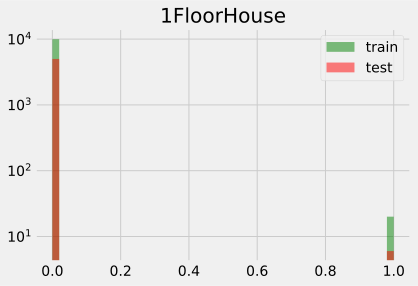

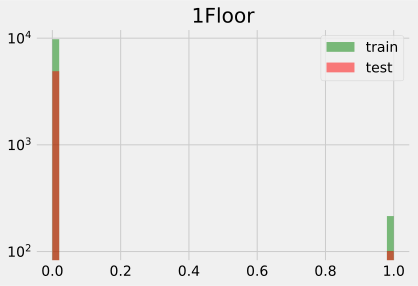

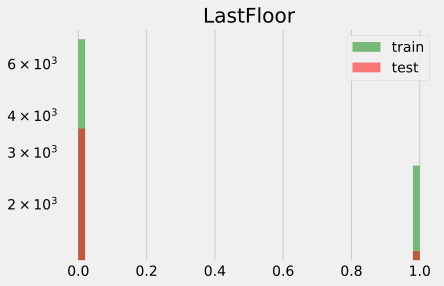

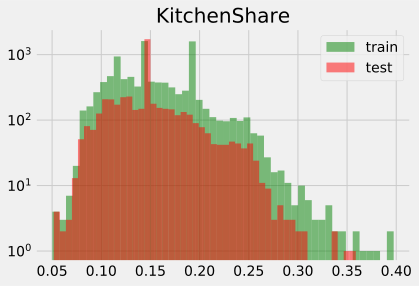

In [540]:
# строим гистограммы чтобы посмотреть как выглядят данные на train и test выборках

def compare(feature):

    plt.hist(df_train[feature], bins=50, alpha  = 0.5, color = 'green', label='train')
    plt.hist(df_test[feature], bins=50, alpha  = 0.5, color = 'red', label='test')
    plt.title(feature)
    plt.legend()
    plt.yscale('log')
    plt.show()

for i in range(1, len(df_test.columns)):
    compare(df_test.columns[i])

Подготовка модели

In [541]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

target = 'Price'
# , 'Shops_2', 'Ecology_2', 'Ecology_3', '1FloorHouse', '1Floor', 'LastFloor'
features = ['DistrictId', 'Square',  'KitchenSquare', 'Floor', 'Rooms', 'HouseYear', 'Ecology_1', 
            'Social_1', 'Social_2', 'Social_2', 'Healthcare_1', 'Healthcare_2', 'Shops_1',  
            'RatioFloor', 'HouseFloor', 'KitchenShare']

y = df_train[target].values.ravel()
x = df_train[features].values

param_grid  = {'max_depth':[19],
                'min_samples_split':[2],
                'min_samples_leaf':[1],
              'n_estimators':[300]}

rf = RandomForestRegressor(  criterion='mse',                           
                             min_weight_fraction_leaf=0.0,
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             min_impurity_split=None,
                             bootstrap=True,
                             oob_score=False,
                             random_state=1,
                             verbose=0,
                             warm_start=False)

grid = GridSearchCV(rf, param_grid = param_grid, cv = 10, 
                    scoring = 'r2') 

grid.fit(x, y)

print(grid.best_estimator_)

print(grid.best_score_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=19,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)
0.7315232117266282


In [542]:
model = grid.best_estimator_.fit(x, y)
feach_import = np.vstack((features, np.round(model.feature_importances_,2))).T
feach_import

array([['DistrictId', '0.06'],
       ['Square', '0.39'],
       ['KitchenSquare', '0.02'],
       ['Floor', '0.02'],
       ['Rooms', '0.08'],
       ['HouseYear', '0.04'],
       ['Ecology_1', '0.04'],
       ['Social_1', '0.1'],
       ['Social_2', '0.05'],
       ['Social_2', '0.06'],
       ['Healthcare_1', '0.04'],
       ['Healthcare_2', '0.01'],
       ['Shops_1', '0.02'],
       ['RatioFloor', '0.02'],
       ['HouseFloor', '0.03'],
       ['KitchenShare', '0.03']], dtype='<U32')

Прогноз

In [543]:
x_test = df_test[features].values
y_test = np.round(model.predict(x_test),1)

output = np.vstack([df_test['Id'].values, y_test]).T

output = pd.DataFrame(output)
output.columns = ['Id', 'Price']
output['Id'] = pd.to_numeric(output['Id'], downcast='integer')

output.to_csv('output.csv', index=False, sep= ',')

EDA

In [455]:
train_room_stat = df_test.groupby(['Rooms']).agg({'Square':['count', 'mean', 'min', 'max']})
train_room_stat

Square                                    
       count        mean         min         max
Rooms                                           
1.0     1769   41.137315   13.305531  163.325901
2.0     2033   56.750914   33.444306  138.039182
3.0     1099   77.201304   35.585010  221.138768
4.0       90   94.501365   37.920348  189.679576
5.0        7  115.788971   56.600162  157.976101
6.0        2  167.101957  110.750226  223.453689

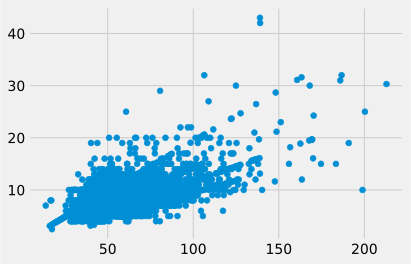

In [406]:
plt.scatter(df_train['Square'], df_train['KitchenSquare'])
plt.show()

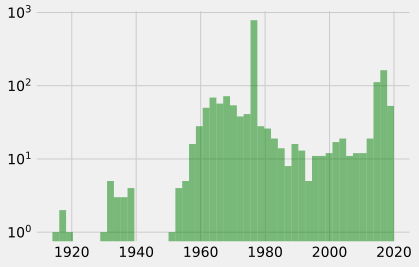

In [359]:
z = df_train.loc[df_train['Floor'] > df_train['HouseFloor']]
plt.hist(z['HouseYear'], bins=50, alpha  = 0.5, color = 'green', label='train')
plt.yscale('log')
plt.show()

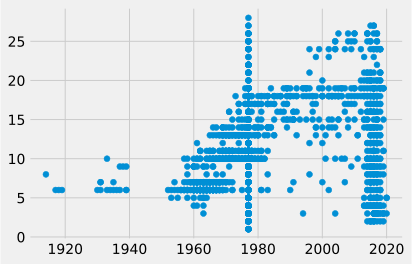

In [360]:
z = df_train.loc[df_train['Floor'] > df_train['HouseFloor']]
plt.scatter(z['HouseYear'], z['Floor'])
plt.show()

In [457]:
df_test.loc[(df_test['KitchenShare'] >= 0.4) | (df_test['KitchenShare'] <=0.05)]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
625    2249          62    1.0   77.157675   78.281763           34.0    5.0   
1419   1823          97    3.0   85.846510   62.139249            4.0    4.0   
1499   7769         124    4.0  189.679576  114.708673            4.0   19.0   
2039   3357          27    3.0  170.476326   75.973612            8.0    2.0   
3451  11193          12    1.0   42.901789   19.755764           19.0    7.0   
3909   1397          76    3.0  221.138768  118.055342            4.0   32.0   

      HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  \
625         24.0       2016   0.072158          1          1         2   
1419         9.0       1941   0.306977          1          1        27   
1499        40.0       2013   0.174739          1          1        17   
2039         2.0       2017   0.041116          1          1        53   
3451        16.0       1980   0.090799          1          1        74   
3909        48.0       2011   0.000000          1          1         7   

      Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1  Shops_2  \
625        629         1   1142.839299             0        0        0   
1419      5148        14   1575.000000             5        7        1   
1499      3379         9    100.000000             0        3        1   
2039     14892         4   1142.839299             1        4        1   
3451     19083         2   1142.839299             5       15        1   
3909      1660        39   1786.000000             1        5        1   

      RatioFloor  1FloorHouse  1Floor  LastFloor  KitchenShare  
625     0.208333            0       0          0      0.440656  
1419    0.444444            0       0          0      0.046595  
1499    0.475000            0       0          0      0.021088  
2039    1.000000            0       0          1      0.046927  
3451    0.437500            0       0          0      0.442872  
3909    0.666667            0       0          0      0.018088

In [458]:
df_train.loc[(df_train['KitchenShare'] >= 0.4) | (df_train['KitchenShare'] <=0.05)]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
3166  15127         150    1.0   17.046188   20.036232            8.0      7   
4525  14773          30    1.0  105.619549   87.387096            5.0     14   
4550  16408           9    1.0   40.226907   37.849083           19.0      8   
4739  12676          81    3.0   13.784865   15.988889            7.0      4   
5617  15877          57    3.0   16.547242   16.698571            8.0      5   
5786   7857          27    2.0   43.956044   10.523868           19.0     15   
7249   3431          62    2.0   60.715426   40.720961           25.0      5   
9064   4769          27    2.0   80.477255   38.604383            4.0      3   

      HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  \
3166        12.0       1982   0.300323          1          1        52   
4525        39.0       2010   0.000078          1          1        22   
4550        17.0       1993   0.161532          1          1        25   
4739         5.0       1960   0.319809          1          1        25   
5617         5.0       1962   0.133215          1          1        49   
5786        17.0       2006   0.075424          1          1        11   
7249        12.0       2012   0.386772          1          1         5   
9064         3.0       2004   0.011654          1          1         4   

      Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1  Shops_2  \
3166     10311         6   1142.839299             1        9        1   
4525      6398       141   1046.000000             3       23        1   
4550      5648         1     30.000000             2        4        1   
4739      4756        16   2857.000000             5        8        1   
5617     11395         3   1406.000000             3        4        0   
5786      3097         0   1142.839299             0        0        1   
7249      1135         0   1142.839299             0        0        0   
9064       915         0   1142.839299             0        0        1   

              Price  RatioFloor  1FloorHouse  1Floor  LastFloor  KitchenShare  
3166   74222.110465    0.583333            0       0          0      0.469313  
4525  476843.942405    0.358974            0       0          0      0.047340  
4550  137595.610782    0.470588            0       0          0      0.472321  
4739   78388.806186    0.800000            0       0          0      0.507803  
5617   77835.185808    1.000000            0       0          1      0.483464  
5786  143688.076514    0.882353            0       0          0      0.432250  
7249  172366.012197    0.416667            0       0          0      0.411757  
9064  158122.321392    1.000000            0       0          1      0.049703

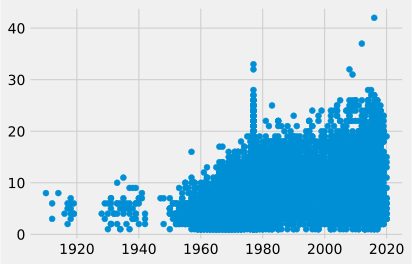

In [466]:
plt.scatter(df_train['HouseYear'], df_train['Floor'])
plt.show()

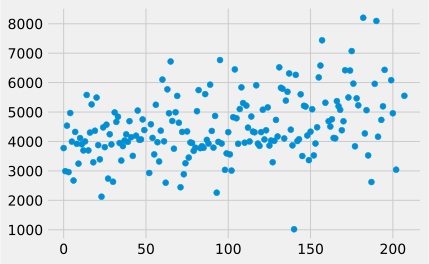

In [472]:
stat = df_train.loc[df_train['Rooms']==3].groupby(['DistrictId']).agg({'Price/m':['mean']})
stat = stat.reset_index()
stat = stat.reset_index(drop=True)
stat.columns = ['_'.join(tup).rstrip('_') for tup in stat.columns.values] 
stat

plt.scatter(stat['DistrictId'], stat['Price/m_mean'])
plt.show()


In [512]:
stat = df_train.groupby(['DistrictId', 'Rooms']).agg({'Price/m':['mean']})
stat = stat.reset_index()
stat = stat.reset_index(drop=True)
stat.columns = ['_'.join(tup).rstrip('_') for tup in stat.columns.values]
stat

Index(['DistrictId', 'Rooms', 'Price/m_mean'], dtype='object')

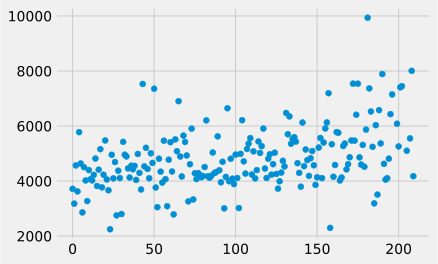

In [535]:
x = pd.pivot_table(stat, values='Price/m_mean', index=['DistrictId'], columns=['Rooms'], 
                   aggfunc=np.mean).reset_index().rename_axis(None, axis=1)

x = x.drop([4.0, 5.0], axis = 1)
#x['mean'] = x[[1.0, 2.0, 3.0]].mean(axis=1)
x['mean'] = x[x.columns[1:]].mean(axis=1, skipna = True)

plt.scatter(x['DistrictId'], x['mean'])
plt.show()

In [534]:
y = pd.pivot_table(stat, values='Price/m_mean', index=['DistrictId'], columns=['Rooms'], 
                   aggfunc='count').reset_index().rename_axis(None, axis=1)

y = y.drop([4.0, 5.0], axis = 1)